# 2-means clustering via Bayesian inference
Calculate best 2-means clustering model using Bayseian inference iteratively. Not very efficient, but maintains a distribution over $2^{n-1}$ possible models with probability of each model being the best 2-means clustering of the $n$ data points.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [41]:
def plot_round(prior, likelihood, posterior, model_range):
    fs = 14
    fig, ax = plt.subplots(figsize=[15,5])
    plt.plot(model_range, prior, linewidth=3, color='palegreen', label='Prior')
    plt.plot(model_range, likelihood, linewidth=3, color='lightsalmon', label='Likelihood')
    plt.plot(model_range, posterior, lw=3, color='skyblue', label='Posterior')
    plt.grid(alpha=.4, linestyle='--')
    plt.legend(fontsize=fs)
    plt.xlabel(r'Clustering model', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.show()
    plt.close()

In [109]:
def gen_gaussian_data(N, dim=2, dist=1, stddev=1.0):
    # generate N random data vectors from two Gaussian clusters
    data = []
    # first cluster is always centered on [0, 0, 0, ...]
    cluster1mean = np.zeros(dim)
    cluster1size = N // 2
    for i in range(cluster1size):
        data.append(np.random.normal(cluster1mean, stddev, (dim)))

    # second cluster is placed along the vector dist*[1, 1, 1, ...]
    cluster2mean = np.zeros(dim) + dist
    for i in range(N-cluster1size):
        data.append(np.random.normal(cluster2mean, stddev, (dim)))
    return np.array(data), cluster1mean, cluster2mean


def plot_data(data):
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(data[:,0], data[:,1])
    ax.axvline(0, ls='--', c='grey')
    ax.axhline(0, ls='--', c='grey')
    plt.show()
    plt.close()

def plot_cluster(data, model):
    cluster0 = []
    cluster1 = []
    for i in range(len(data)):
        if model & 0x1 == 1:
            cluster1.append(data[i])
        else:
            cluster0.append(data[i])
        model >>= 1
    cluster0 = np.array(cluster0)
    cluster1 = np.array(cluster1)
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(cluster0[:,0], cluster0[:,1], c='r')
    ax.scatter(cluster1[:,0], cluster1[:,1], c='b')
    plt.show()
    plt.close()

For a given data point $x$, we would like to weight each model by the distance $x$ is from its assigned cluster center. We want maximum values to correspond to a minimum of this distance, so we negate it. \
Model our likelihood function as:   
 $\pi(y_k) = e^{-||x-y_k||} / Z$ \
where $Z = \sum_{k}e^{-||x-y_k||}$ \
and $y_k$ is the cluster $x$ is assigned to in the $k^{th}$ clustering model

In [100]:
# TODO: Have x be a coreset instead of a single data point?
def calculate_likelihood(x: np.ndarray, model_clusters: np.ndarray) -> np.ndarray:
    likelihood = np.exp(-np.linalg.norm(x - model_clusters, axis=1))
    return likelihood / np.sum(likelihood)

In [62]:
def convert_bitstring_to_clusters(model: int, data: np.ndarray) -> np.ndarray:
    # Calculate the 2 cluster centers for a given model, which is an integer we treat as a bitstring.
    # Assume MSB is cluster 0 so no symmetry in cluster labels
    num_cluster0 = 0
    num_cluster1 = 0
    cluster0 = np.array([0.0, 0.0])
    cluster1 = np.array([0.0, 0.0])
    for i in range(len(data)):
        if model & 0x1 == 1:
            cluster1 += data[i]
            num_cluster1 += 1
        else:
            cluster0 += data[i]
            num_cluster0 += 1
        model >>= 1
    if num_cluster0 > 0:
        cluster0 /= num_cluster0
    if num_cluster1 > 0:
        cluster1 /= num_cluster1
    return np.array([cluster0, cluster1])

def get_clusters_for_data(data_idx: int, model_clusters: np.ndarray) -> np.ndarray:
    # Calculate the list of cluster centers, 1 per model, a given data point is assigned to
    return np.array([model_clusters[i][(i >> data_idx) & 0x1] for i in range(len(model_clusters))])

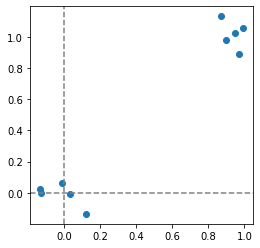

In [126]:
num_data = 10
data, true_c1, true_c2 = gen_gaussian_data(N=num_data, stddev=0.1)
np.random.shuffle(data)
plot_data(data)

In [133]:
# Implicitly assign last data point cluster 0 to remove symmetry in cluster labels
num_models = 2**(num_data - 1)

# Precompute the 2 cluster centers for each model
model_clusters = np.array([convert_bitstring_to_clusters(model, data) for model in range(num_models)])

# Use uniform distribution over all models for prior
prior = stats.uniform.pdf(np.zeros(num_models), loc=0, scale=num_models)

Bayesian inference, round 0


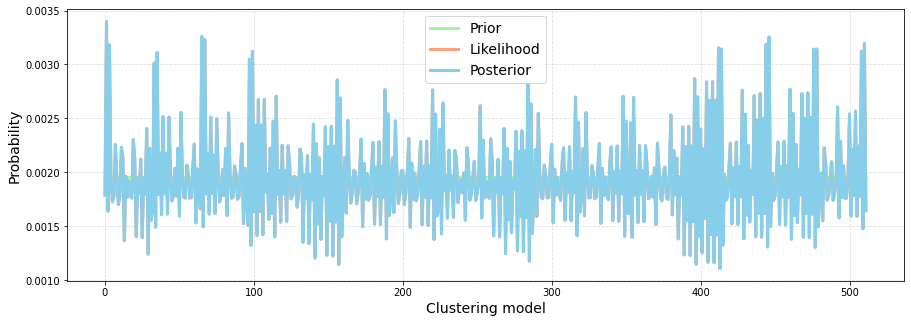

Bayesian inference, round 1


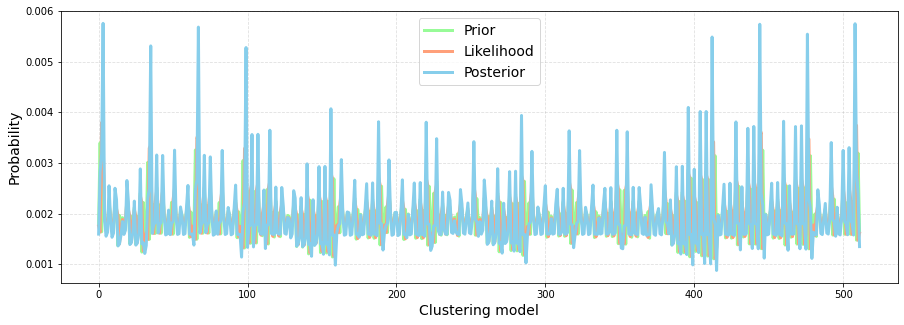

Bayesian inference, round 2


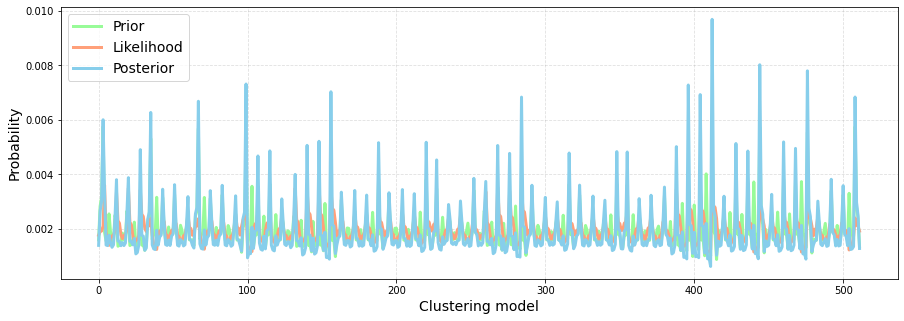

Bayesian inference, round 3


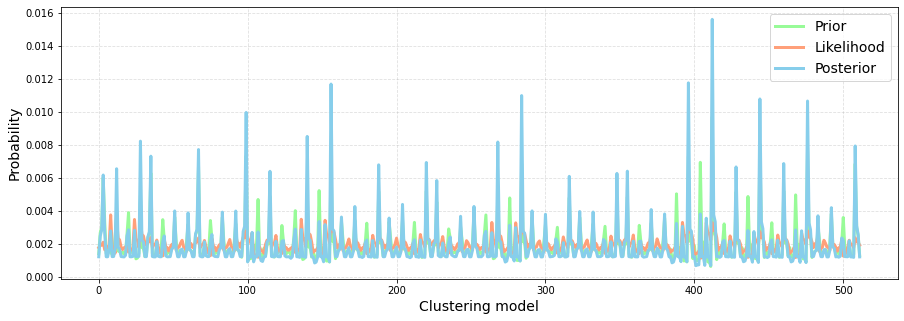

Bayesian inference, round 4


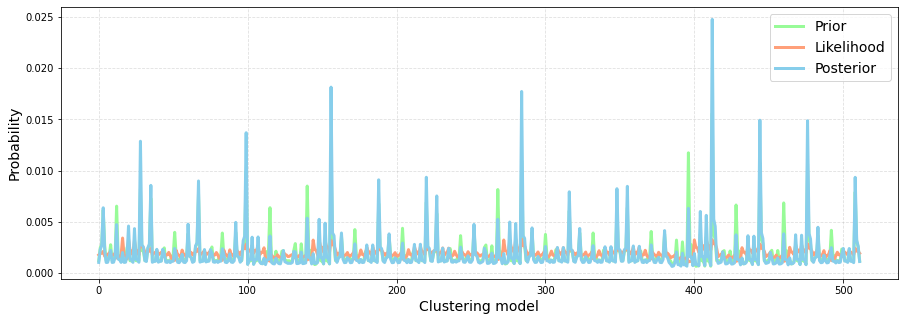

Bayesian inference, round 5


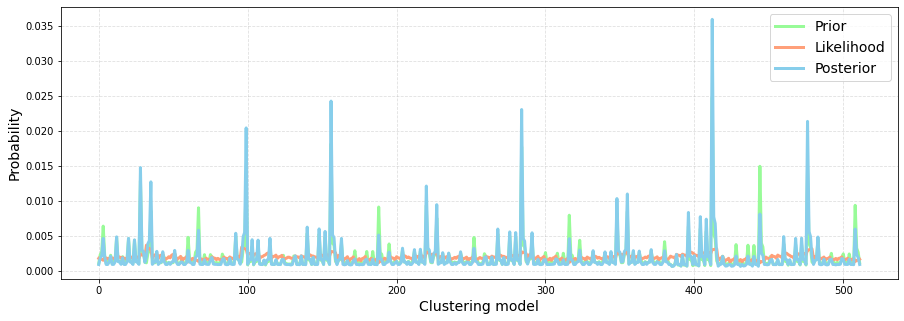

Bayesian inference, round 6


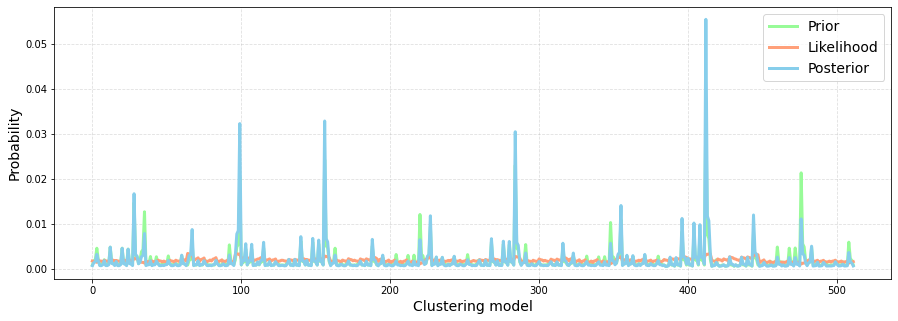

Bayesian inference, round 7


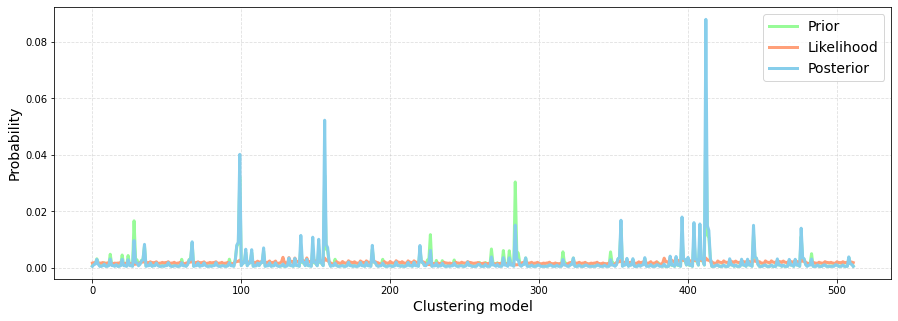

Bayesian inference, round 8


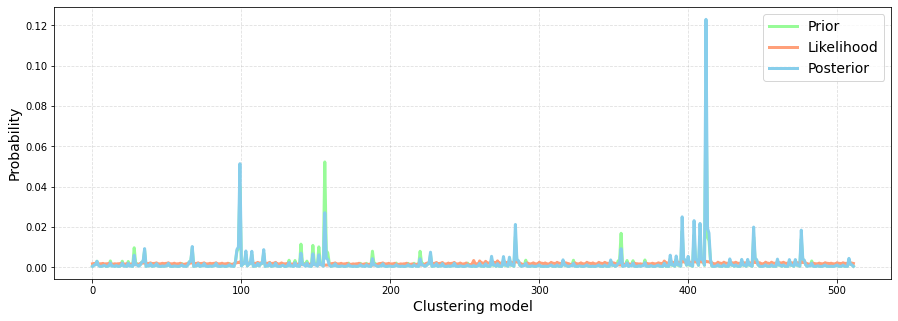

In [134]:
# Iteratively grab a new data point and use bayesian inference to update our distribution for which model is best
for rnd in range(num_data - 1):
    print(f'Bayesian inference, round {rnd}')
    curr_clusters = get_clusters_for_data(rnd, model_clusters)
    likelihood = calculate_likelihood(data[rnd], curr_clusters)
    posterior = prior * likelihood
    posterior /= np.sum(posterior)
    plot_round(prior, likelihood, posterior, range(num_models))
    prior = posterior
model = np.argmax(prior)

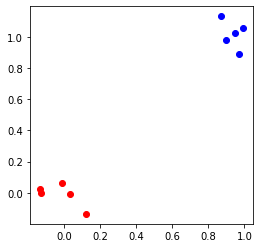

In [135]:
plot_cluster(data, model)